# STAT3009 Project 1
- LAW Yiu Leung Eric 1155149315
- LAM Wai Chiu 1155152095
- TSOI Tung Sing 1155127274

## Import packages and load the developed methods

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for j in range(n_obs):
                user_id, item_id, rating_tmp = train_pair[j,0], train_pair[j,1], train_rating[j]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate*err_tmp*self.P[user_id,:] - 2*learning_rate*lam*self.Q[item_id,:]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*self.Q[item_id,:] - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - score_new + score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

In [3]:
# define class for correlation based RS
from numpy.linalg import norm
from scipy.sparse import lil_matrix

class cor_rs_user(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
		self.S = lil_matrix((n_user, n_user))
		self.index_item = []
		self.index_user = []
		self.min_co = 3
	
	def cossim(self, index_u, index_v, train_pair, train_rating):
		item_u = train_pair[index_u][:,1]
		item_v = train_pair[index_v][:,1]
		# find co-rating items by `set`
		item_co = list(set(item_u).intersection(set(item_v)))
		if len(item_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			# find the co-rating vectors by using `np.isin`
			vec_u, vec_v = train_rating[index_u], train_rating[index_v]
			ind_co_u = [np.where(item_u == item_co_tmp)[0][0] for item_co_tmp in item_co]
			ind_co_v = [np.where(item_v == item_co_tmp)[0][0] for item_co_tmp in item_co]
			vec_co_u, vec_co_v = vec_u[ind_co_u], vec_v[ind_co_v]			
			return np.dot(vec_co_u, vec_co_v) / (norm(vec_co_u)+1e-5) / (norm(vec_co_v)+1e-5)
	
	def sim_mat(self, train_pair, train_rating):
		self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
		for u in range(self.n_user):
			for v in range(u):
				if (len(self.index_user[u]) == 0) or (len(self.index_user[v]) == 0):
					continue
				weight_tmp = self.cossim(self.index_user[u],self.index_user[v],train_pair,train_rating)
				if weight_tmp > 0:
					self.S[u,v] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		# use another class to predict the user mean
		user_ave_method = user_mean(self.n_user)
		user_ave_method.fit(train_pair, train_rating)
		self.user_mean = user_ave_method.user_mean
		self.sim_mat(train_pair, train_rating)
	
	def predict(self, test_pair, train_pair, train_rating, top=10):
		pred = np.zeros(len(test_pair))
		for j in range(len(test_pair)):
			user_tmp, item_tmp = test_pair[j,0], test_pair[j,1]
			index_tmp = self.index_item[item_tmp]
			rated_users = train_pair[index_tmp][:,0]
			rated_ratings = train_rating[index_tmp]
			sim_weight = self.S[user_tmp, rated_users].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_users) == 0) or (max(sim_weight_knn) == 0):
				# if no rated users or no similar users
				pred[j] = self.user_mean[user_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred


class cor_rs_item(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
		self.S = lil_matrix((n_item, n_item))
		self.index_item = []
		self.index_user = []
		self.min_co = 3

	def cossim(self, index_i, index_j, train_pair, train_rating):
		# index_u = np.where(train_pair[:,0] == u)[0]
		# index_v = np.where(train_pair[:,0] == v)[0]
		user_i = train_pair[index_i][:,0]
		user_j = train_pair[index_j][:,0]
		# find co-rating items by `set`
		user_co = list(set(user_i).intersection(set(user_j)))
		if len(user_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			# find the co-rating vectors by using `np.where`
			vec_i, vec_j = train_rating[index_i], train_rating[index_j]
			ind_co_i = [np.where(user_i == user_co_tmp)[0][0] for user_co_tmp in user_co]
			ind_co_j = [np.where(user_j == user_co_tmp)[0][0] for user_co_tmp in user_co]
			vec_co_i, vec_co_j = vec_i[ind_co_i], vec_j[ind_co_j]
			return np.dot(vec_co_i, vec_co_j) / (norm(vec_co_i)+1e-5) / (norm(vec_co_j)+1e-5)
	
	def sim_mat(self, train_pair, train_rating):
		self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
		for i in range(self.n_item):
			for j in range(i):
				if (len(self.index_item[i]) == 0) or (len(self.index_item[j]) == 0):
					continue
				weight_tmp = self.cossim(self.index_item[i],self.index_item[j],train_pair,train_rating)
				if weight_tmp > 0:
					self.S[i,j] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		# use another class to predict the item mean
		item_ave_method = item_mean(self.n_item)
		item_ave_method.fit(train_pair, train_rating)
		self.item_mean = item_ave_method.item_mean
		self.sim_mat(train_pair, train_rating)
	
	def predict(self, test_pair, train_pair, train_rating, top=10):
		pred = np.zeros(len(test_pair))
		for j in range(len(test_pair)):
			user_tmp, item_tmp = test_pair[j,0], test_pair[j,1]
			index_tmp = self.index_user[user_tmp]
			rated_items = train_pair[index_tmp][:,1]
			rated_ratings = train_rating[index_tmp]
			sim_weight = self.S[item_tmp, rated_items].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_items) == 0) or (max(sim_weight_knn) == 0):
				# if no rated items or no similar items
				pred[j] = self.item_mean[item_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# Pre-process the raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- create `train_pair`,`train_rating`, `test_pair`

This part is contributed by `TSOI Tung Sing 1155127274`

In [3]:
dtrain = pd.read_csv("data/train.csv")
dtest = pd.read_csv("data/test.csv")

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

Create train_pair, train_rating and test_pair

In [4]:
# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

# Exploratory Data Analysis (EDA)
This part is contributed by `Tsoi Tung Sing 1155127274`

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Data Type

In [5]:
print( 'Data Type of "user_id" :', type(dtrain['user_id'][0]))
print( 'Data Type of "item_id" :', type(dtrain['item_id'][0]))
print( 'Data Type of "rating" :', type(dtrain['rating'][0]))

Data Type of "user_id" : <class 'str'>
Data Type of "item_id" : <class 'str'>
Data Type of "rating" : <class 'numpy.int64'>


* Both 'user_id' & 'item_id' are str. 
* So, we have to transform them into int. 

### Change Data Type 

In [7]:
## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

In [8]:
print( 'Data Type of "user_id" :', type(dtrain['user_id'][0]))
print( 'Data Type of "item_id" :', type(dtrain['item_id'][0]))
print( 'Data Type of "rating" :', type(dtrain['rating'][0]))

Data Type of "user_id" : <class 'numpy.int64'>
Data Type of "item_id" : <class 'numpy.int64'>
Data Type of "rating" : <class 'numpy.int64'>


* All data are int after changing data type

## Summary of the Dataset

In [7]:
print("Number of users: {n_user}\nNumber of items: {n_item}".format(n_user = n_user, n_item = n_item))
print("Number of records (rows): {n_rows}".format(n_rows = len(dtrain)))
print("Unique ratings: ", list(set(dtrain["rating"])))

Number of users: 492
Number of items: 959
Number of records (rows): 15303
Unique ratings:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


The target variable is `rating`, which is discrete within [0, 15]. The explanatory variables are `user_id` and `item_id`, they are both nominal categorical data.

## Analysis on Rating 

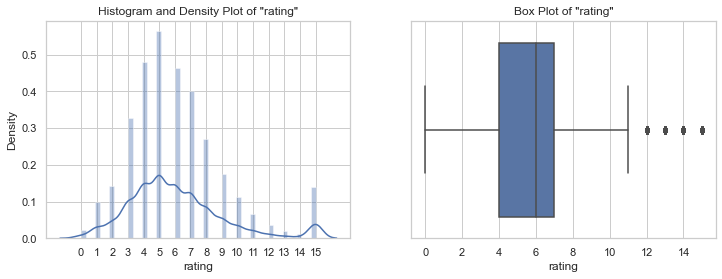

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of "rating"' )
axes[1].set_title('Box Plot of "rating"' )
sns.set_theme(style="whitegrid")
p = sns.distplot(dtrain['rating'],  hist=True, kde=True , ax=axes[0])
p.set( xticks = np.arange(15+1))
box = sns.boxplot(x=dtrain['rating'] , ax=axes[1])

In [13]:
from scipy.stats import skew, kurtosis
print( 'Mean of "rating" =', dtrain['rating'].mean())
print( 'Median of "rating" =', dtrain['rating'].median())
print( 'Variance of "rating" =',( dtrain['rating'].std() )**2 )
print( 'Skewness of "rating" =', skew( dtrain['rating']))
print( 'kurtosis of "rating" =', kurtosis( dtrain['rating'], fisher = False))
print('')
print( 'Top 3 highest frequency of "rating" :')
print(dtrain['rating'].value_counts()[0:3])
print('')
print( 'Top 3 lowest frequency of "rating" :')
print(dtrain['rating'].value_counts()[:-4:-1])

Mean of "rating" = 6.0654120107168525
Median of "rating" = 6.0
Variance of "rating" = 9.553752619086973
Skewness of "rating" = 1.0012392053736987
kurtosis of "rating" = 4.221658881520365

Top 3 highest frequency of "rating" :
5    2587
4    2207
6    2130
Name: rating, dtype: int64

Top 3 lowest frequency of "rating" :
14     48
13     86
0     108
Name: rating, dtype: int64


* From the graphs and statistic above, we have:
* Ratings bigger or equal to 12 are outliers
* Most people give 4 to 6 rating
* The Distribution of rating looks like a trianglar distribution centered at 5 but with many extreme values at 15
* Using global mean may not be a good idea with a lot of extreme values
* Since skewness > 1, the distribution is highly skewed to right
* "rating" data has more weight in the left tail of the distribution.
* Since kurtosis > 4, rating data has much heavier tails than a normal distribution

## Rating count

No. of users give only 5 or less rating = 79
No. of items with only 5 or less rating = 196


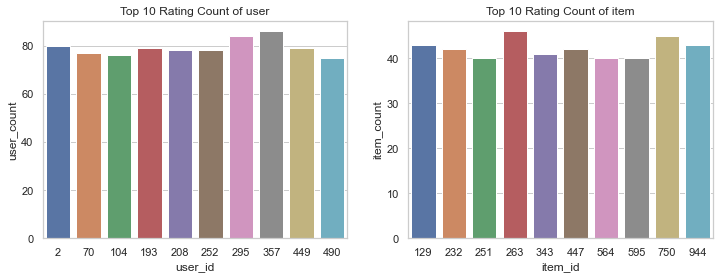

In [14]:
user_count = dtrain.groupby("user_id").size()
user_count = pd.DataFrame( data = user_count.values, index = range(len(user_count)) )
user_count.columns = ['user_count']
u_count = user_count.sort_values( by = 'user_count')[-10:]

item_count = dtrain.groupby("item_id").size()
item_count = pd.DataFrame( data = item_count.values, index = range(len(item_count)) )
item_count.columns = ['item_count']
i_count = item_count.sort_values( by = 'item_count')[-10:]

fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Top 10 Rating Count of user' )
axes[1].set_title('Top 10 Rating Count of item' )
sns.set_theme(style="whitegrid")
a = sns.barplot(x = u_count.index, y = 'user_count', data = u_count , ax=axes[0])
a.set(xlabel='user_id')
b = sns.barplot(x = i_count.index, y = 'item_count', data = i_count , ax=axes[1])
b.set(xlabel='item_id')
print('No. of users give only 5 or less rating =', np.where(user_count.sort_values(by = 'user_count') == 6)[0][0] - 1)
print( 'No. of items with only 5 or less rating =', np.where(item_count.sort_values( by = 'item_count') == 6)[0][0] - 1)


## Average Rating

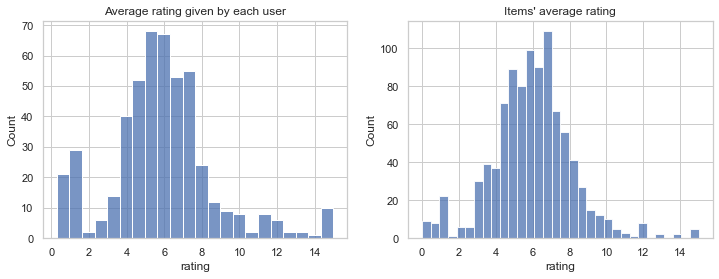

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title("Average rating given by each user")
axes[1].set_title("Items' average rating")

# Average rating given by each user
g = sns.histplot(x = dtrain.groupby("user_id")["rating"].mean(), ax=axes[0])#.set_xticks(range(15+1))
# Histogram of items' average rating
p = sns.histplot(x = dtrain.groupby("item_id")["rating"].mean(), ax=axes[1])#.set_xticks(range(15+1))

* user mean and item mean are plotted above individually.
* From the user mean graph, there are many extreme values, which means many users only give 0, 1 or 15 rating.
* From the item mean graph, there are some extreme values on the left, which means some items only have 0, 1 rating.
* Considering user mean & item mean separately in the RS could take all these into account.

### Correlation between user mean and user rating count

In [16]:
pd.DataFrame(pd.concat([dtrain.groupby("user_id")["rating"].mean(),user_count ], axis = 1)).corr()

,rating,user_count
rating,1.000000,0.095614
user_count,0.095614,1.000000


### Correlation between item mean and item rating count

In [17]:
pd.DataFrame(pd.concat([dtrain.groupby("item_id")["rating"].mean(),item_count ], axis = 1)).corr()

,rating,item_count
rating,1.000000,-0.007782
item_count,-0.007782,1.000000


* There is no strong relationship between user mean and user rating count & item mean and item rating count
* We will not take rating frequancy into account in RS

## Find Top-20 highest Rating Items
Calculate the average rating of each items, then find the top 20

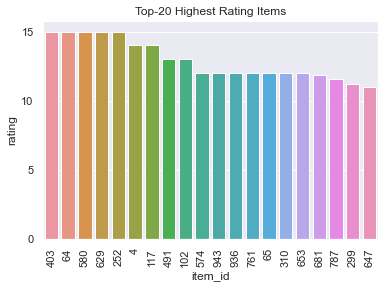

In [13]:
top20_item = dtrain.groupby("item_id")["rating"].mean().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Highest Rating Items", yticks = range(0, 15+1, 5))
g.tick_params(axis = "x", rotation = 90)
plt.show(g)

## Find Top-20 Most Popular Items
Count the number of ratings of each items, then find the top 20

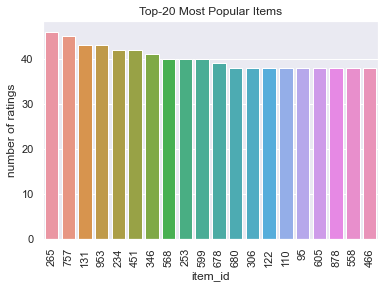

In [14]:
top20_item = dtrain.groupby("item_id")["rating"].count().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Most Popular Items", ylabel = "number of ratings")
g.tick_params(axis='x', rotation=90)
plt.show(g)

# Use the Developed Methods
This part is contributed by `LAM Wai Chiu 1155152095`
## GLB_LFM (performance in public leaderboard: 1.57487)  
(i) Any hyperparameters? how to tune; (ii)Any issue? (iii) how to make improvement.
* Hyperparameters: K = 3, lamda = 0.00050 were used after 5-Fold Cross Validation
* It gives a bad result as what we thought.
* From the EDA, we found that there are lots of extreme values in rating. It is dangerous to global mean because global mean will average out those extreme point.
* We must introduce user mean and item mean to avoid that.

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.487, valid_rmse: 3.598
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.530, valid_rmse: 3.473
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.453, valid_rmse: 3.484
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.457, valid_rmse: 3.532
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.469, valid_rmse: 3.489
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.502, valid_rmse: 3.573
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.452, valid_rmse: 3.531
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.555, valid_rmse: 3.491
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.498, valid_rmse: 3.493
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.515, valid_rmse: 3.527
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.489, valid_rmse: 3.525
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.473, valid_rmse: 3.470
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.485, valid_rmse: 3.485
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.464, valid_rmse: 3.527
5-Fold

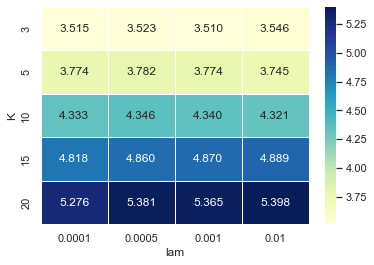

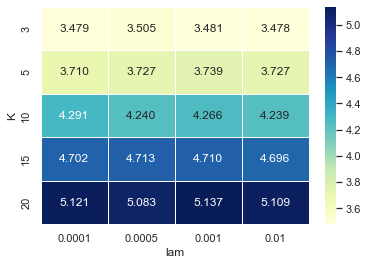

Fitting Reg-LFM: K: 3, lam: 0.00100
Reg-LFM: ite: 0; diff: 0.006 RMSE: 3.534
Reg-LFM: ite: 1; diff: 0.006 RMSE: 3.528
Reg-LFM: ite: 2; diff: 0.006 RMSE: 3.522
Reg-LFM: ite: 3; diff: 0.006 RMSE: 3.516
Reg-LFM: ite: 4; diff: 0.006 RMSE: 3.510
Reg-LFM: ite: 5; diff: 0.006 RMSE: 3.504
Reg-LFM: ite: 6; diff: 0.006 RMSE: 3.498
Reg-LFM: ite: 7; diff: 0.006 RMSE: 3.493
Reg-LFM: ite: 8; diff: 0.006 RMSE: 3.487
Reg-LFM: ite: 9; diff: 0.006 RMSE: 3.481


In [15]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
train_rating_cm = train_rating - glb_ave.predict(train_pair)

## fit GLB_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_cm)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_cm)
pred = pred_glb + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "glb_LFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## GLB_user_mean_LFM (performance in public leaderboard: 1.71924)
(i) Any hyperparameters? how to tune; (ii)Any issue? (iii) how to make improvement.
* we introduce a new parameter user mean in this RS
* Hyperparameters: K = 15, lamda = 0.00050 were used after 5-Fold Cross Validation
* It gives a even worst result.
* There is a big change in optimal K in this RS, which means that it takes more latent factors to explain the features of users and items.
* And it eventually make us expose to the risk of overfitting with a big drop in in-sample RMSE (from 1.155 to 0.798) but a big rise in outsample RMSE
* Therefore we will try to use item mean instead

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.482, valid_rmse: 2.484
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.497, valid_rmse: 2.492
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.466, valid_rmse: 2.458
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.505, valid_rmse: 2.596
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.477, valid_rmse: 2.439
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.483, valid_rmse: 2.453
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.503, valid_rmse: 2.461
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.533, valid_rmse: 2.558
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.513, valid_rmse: 2.515
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.570, valid_rmse: 2.614
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.530, valid_rmse: 2.545
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.497, valid_rmse: 2.554
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.490, valid_rmse: 2.482
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.442, valid_rmse: 2.446
5-Fold

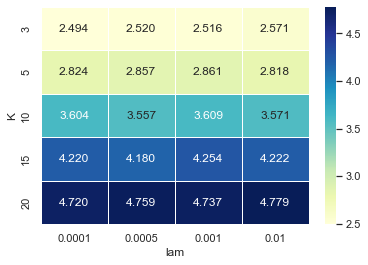

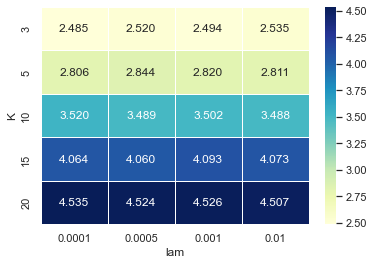

Fitting Reg-LFM: K: 3, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.008 RMSE: 2.571
Reg-LFM: ite: 1; diff: 0.008 RMSE: 2.563
Reg-LFM: ite: 2; diff: 0.008 RMSE: 2.555
Reg-LFM: ite: 3; diff: 0.008 RMSE: 2.548
Reg-LFM: ite: 4; diff: 0.007 RMSE: 2.541
Reg-LFM: ite: 5; diff: 0.007 RMSE: 2.533
Reg-LFM: ite: 6; diff: 0.007 RMSE: 2.526
Reg-LFM: ite: 7; diff: 0.007 RMSE: 2.519
Reg-LFM: ite: 8; diff: 0.007 RMSE: 2.512
Reg-LFM: ite: 9; diff: 0.007 RMSE: 2.505


In [16]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "glb_user_LFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## GLB_item_mean_LFM (performance in public leaderboard: 2.49205)
(i) Any hyperparameters? how to tune; (ii)Any issue? (iii) how to make improvement.
* we introduce a new parameter itam mean in this RS
* Hyperparameters: K = 10, lamda = 0.00050 were used after 5-Fold Cross Validation.
* It is the worst RS model.
* The optimal K have a small change this time but the lamda still doesn't change
* The rise in RMSE shows the importance on user mean.
* From the EDA above, we can see the extreme values appear in the right tail of the distribution of rating and user mean. But for the item mean, the extreme values appear in the left tail of the distribution, which make RS with only item mean but no user mean having a strong bias.
* Therefore, we need to keep user mean in the next model

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.146, valid_rmse: 3.169
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.140, valid_rmse: 3.179
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.067, valid_rmse: 3.083
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.111, valid_rmse: 3.007
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 3.123, valid_rmse: 3.114
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.131, valid_rmse: 3.153
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.079, valid_rmse: 3.050
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.109, valid_rmse: 3.198
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.123, valid_rmse: 3.107
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 3.089, valid_rmse: 3.120
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.166, valid_rmse: 3.190
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.124, valid_rmse: 3.166
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.093, valid_rmse: 3.063
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 3.124, valid_rmse: 3.164
5-Fold

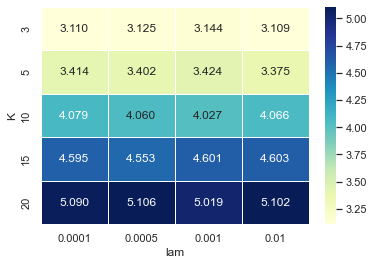

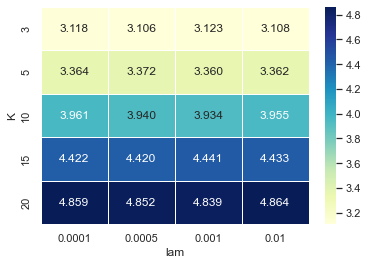

Fitting Reg-LFM: K: 3, lam: 0.01000
Reg-LFM: ite: 0; diff: 0.007 RMSE: 3.176
Reg-LFM: ite: 1; diff: 0.007 RMSE: 3.169
Reg-LFM: ite: 2; diff: 0.007 RMSE: 3.162
Reg-LFM: ite: 3; diff: 0.007 RMSE: 3.156
Reg-LFM: ite: 4; diff: 0.007 RMSE: 3.149
Reg-LFM: ite: 5; diff: 0.007 RMSE: 3.142
Reg-LFM: ite: 6; diff: 0.007 RMSE: 3.136
Reg-LFM: ite: 7; diff: 0.007 RMSE: 3.129
Reg-LFM: ite: 8; diff: 0.006 RMSE: 3.123
Reg-LFM: ite: 9; diff: 0.006 RMSE: 3.116


In [17]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)

# fit GLB + item_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "glb_item_LFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## user_item_mean_LFM (performance in public leaderboard: 1.22190)
(i) Any hyperparameters? how to tune; (ii)Any issue? (iii) how to make improvement.
* We keep both item mean and user mean 
* Hyperparameters: K = 15, lamda = 0.00010 were used after 5-Fold Cross Validation.
* It is the best RS model so far.
* The optimal K is the same as user_mean_LMF but the lamda a little bit bigger this time, since we have more paramters this time 
* The drop in RMSE shows the importance on user mean.
* We believe this could be one of the best RS. Therefore, we will try to do cross validation with more K and lamda with this model

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.028, valid_rmse: 2.013
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.997, valid_rmse: 2.044
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.996, valid_rmse: 2.049
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.012, valid_rmse: 2.080
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.020, valid_rmse: 2.115
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.028, valid_rmse: 2.044
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.994, valid_rmse: 1.972
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.002, valid_rmse: 2.002
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.037, valid_rmse: 2.014
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.073, valid_rmse: 2.062
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.069, valid_rmse: 2.046
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.982, valid_rmse: 2.064
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.074, valid_rmse: 2.027
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.983, valid_rmse: 2.017
5-Fold

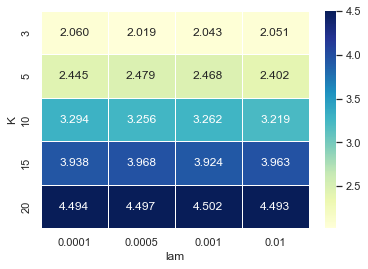

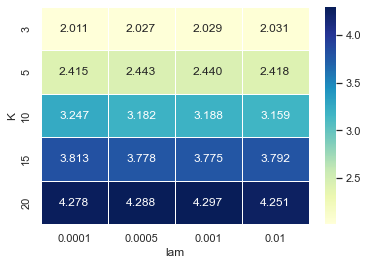

Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.007 RMSE: 2.003
Reg-LFM: ite: 1; diff: 0.007 RMSE: 1.996
Reg-LFM: ite: 2; diff: 0.007 RMSE: 1.989
Reg-LFM: ite: 3; diff: 0.007 RMSE: 1.981
Reg-LFM: ite: 4; diff: 0.007 RMSE: 1.974
Reg-LFM: ite: 5; diff: 0.007 RMSE: 1.967
Reg-LFM: ite: 6; diff: 0.007 RMSE: 1.960
Reg-LFM: ite: 7; diff: 0.007 RMSE: 1.953
Reg-LFM: ite: 8; diff: 0.007 RMSE: 1.946
Reg-LFM: ite: 9; diff: 0.007 RMSE: 1.939


In [18]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "user_item_LFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## Set more $K$ and $\lambda$ (performance in public leaderboard: 1.17941)
* A new set of K = [15,16,17,18,19,20], [0.0003,0.00035,0.0004]
* Hyperparameters: K = 16, lamda = 0.00040 were used after 5-Fold Cross Validation.
* It is the better than the last model , which means we have found a better set of hyperparameters

5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.898, valid_rmse: 4.100
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.724, valid_rmse: 3.861
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.798, valid_rmse: 3.947
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.767, valid_rmse: 3.916
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.884, valid_rmse: 3.864
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.685, valid_rmse: 3.850
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.775, valid_rmse: 3.948
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.876, valid_rmse: 3.842
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.825, valid_rmse: 3.905
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.763, valid_rmse: 3.923
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.791, valid_rmse: 3.878
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.768, valid_rmse: 3.882
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.738, valid_rmse: 3.911
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.808, valid_rmse

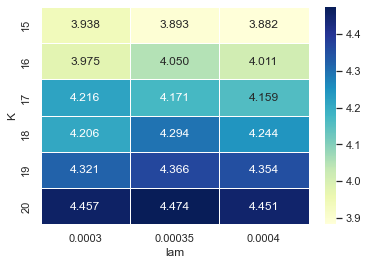

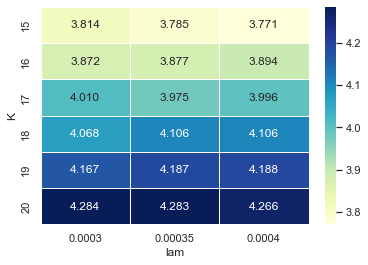

Fitting Reg-LFM: K: 15, lam: 0.00040
Reg-LFM: ite: 0; diff: 0.031 RMSE: 4.109
Reg-LFM: ite: 1; diff: 0.030 RMSE: 4.079
Reg-LFM: ite: 2; diff: 0.030 RMSE: 4.049
Reg-LFM: ite: 3; diff: 0.030 RMSE: 4.019
Reg-LFM: ite: 4; diff: 0.029 RMSE: 3.990
Reg-LFM: ite: 5; diff: 0.029 RMSE: 3.961
Reg-LFM: ite: 6; diff: 0.029 RMSE: 3.933
Reg-LFM: ite: 7; diff: 0.028 RMSE: 3.905
Reg-LFM: ite: 8; diff: 0.028 RMSE: 3.877
Reg-LFM: ite: 9; diff: 0.027 RMSE: 3.849
Reg-LFM: ite: 10; diff: 0.027 RMSE: 3.822
Reg-LFM: ite: 11; diff: 0.027 RMSE: 3.796
Reg-LFM: ite: 12; diff: 0.026 RMSE: 3.769
Reg-LFM: ite: 13; diff: 0.026 RMSE: 3.743
Reg-LFM: ite: 14; diff: 0.026 RMSE: 3.717
Reg-LFM: ite: 15; diff: 0.025 RMSE: 3.692
Reg-LFM: ite: 16; diff: 0.025 RMSE: 3.667
Reg-LFM: ite: 17; diff: 0.025 RMSE: 3.642
Reg-LFM: ite: 18; diff: 0.025 RMSE: 3.617
Reg-LFM: ite: 19; diff: 0.024 RMSE: 3.593
Reg-LFM: ite: 20; diff: 0.024 RMSE: 3.569
Reg-LFM: ite: 21; diff: 0.024 RMSE: 3.546
Reg-LFM: ite: 22; diff: 0.023 RMSE: 3.522
Reg-LFM

In [19]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)


## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [15,16,17,18,19,20],[0.0003,0.00035,0.0004]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam,iterNum=30)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "user_item_LFM_extra"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## sLFM for user_item_mean_LFM (performance in public leaderboard: 1.43857)
* Hyperparameters: K = 3, lam = 0.01000 were used after 5-Fold Cross Validation.

In [20]:
from sklearn.preprocessing import StandardScaler

dtrain['res_rating'] = train_rating_res

user_info = pd.DataFrame({'user_id': list(range(n_user))})
user_info = user_info.set_index('user_id')
user_info['mean'] = dtrain.groupby('user_id')['res_rating'].mean()
user_info['q1'] = dtrain.groupby('user_id')['res_rating'].quantile(.1)
user_info['q3'] = dtrain.groupby('user_id')['res_rating'].quantile(.3)
user_info['q5'] = dtrain.groupby('user_id')['res_rating'].quantile(.5)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.7)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)


item_info = pd.DataFrame({'item_id': list(range(n_item))})
item_info = item_info.set_index('item_id')
item_info['mean'] = dtrain.groupby('item_id')['res_rating'].mean()
item_info['q1'] = dtrain.groupby('item_id')['res_rating'].quantile(.1)
item_info['q3'] = dtrain.groupby('item_id')['res_rating'].quantile(.3)
item_info['q5'] = dtrain.groupby('item_id')['res_rating'].quantile(.5)
item_info['q7'] = dtrain.groupby('item_id')['res_rating'].quantile(.7)
item_info['q7'] = dtrain.groupby('item_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

In [21]:
user_info

array([[-0.21002926, -0.44897003, -0.60557075,  0.07925146,  0.46150664],
       [-0.00429153,  0.02231299, -0.08386946,  0.17809978,  0.48686177],
       [ 0.11726747, -0.31749303, -0.18781388, -0.00412349,  0.45707553],
       ...,
       [-0.54833334,  0.25794991,  0.08819271, -0.6959374 , -1.22422098],
       [-0.23806032,  0.14190889,  0.38068749, -0.02112492, -0.73086773],
       [-0.08126426,  0.46528331,  0.24447026,  0.10722004, -0.57224061]])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [23]:
top = 5
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pair[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2
UserId: 3
UserId: 4
UserId: 5
UserId: 6
UserId: 7
UserId: 8
UserId: 9
UserId: 10
UserId: 11
UserId: 12
UserId: 13
UserId: 14
UserId: 15
UserId: 16
UserId: 17
UserId: 18
UserId: 19
UserId: 20
UserId: 21
UserId: 22
UserId: 23
UserId: 24
UserId: 25
UserId: 26
UserId: 27
UserId: 28
UserId: 29
UserId: 30
UserId: 31
UserId: 32
UserId: 33
UserId: 34
UserId: 35
UserId: 36
UserId: 37
UserId: 38
UserId: 39
UserId: 40
UserId: 41
UserId: 42
UserId: 43
UserId: 44
UserId: 45
UserId: 46
UserId: 47
UserId: 48
UserId: 49
UserId: 50
UserId: 51
UserId: 52
UserId: 53
UserId: 54
UserId: 55
UserId: 56
UserId: 57
UserId: 58
UserId: 59
UserId: 60
UserId: 61
UserId: 62
UserId: 63
UserId: 64
UserId: 65
UserId: 66
UserId: 67
UserId: 68
UserId: 69
UserId: 70
UserId: 71
UserId: 72
UserId: 73
UserId: 74
UserId: 75
UserId: 76
UserId: 77
UserId: 78
UserId: 79
UserId: 80
UserId: 81
UserId: 82
UserId: 83
UserId: 84
UserId: 85
UserId: 86
UserId: 87
UserId: 88
UserId: 89
UserId: 90
UserId: 9

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.513, valid_rmse: 1.520
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.506, valid_rmse: 1.511
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.505, valid_rmse: 1.523
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.526, valid_rmse: 1.538
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.519, valid_rmse: 1.524
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.508, valid_rmse: 1.521
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.520, valid_rmse: 1.516
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.511, valid_rmse: 1.518
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.515, valid_rmse: 1.526
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.507, valid_rmse: 1.519
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.514, valid_rmse: 1.527
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.523, valid_rmse: 1.544
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.522, valid_rmse: 1.536
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.530, valid_rmse: 1.541
5-Fold

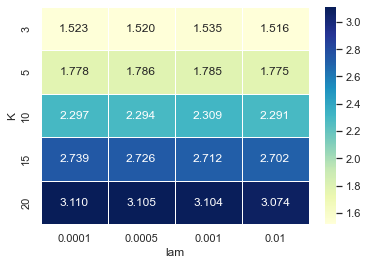

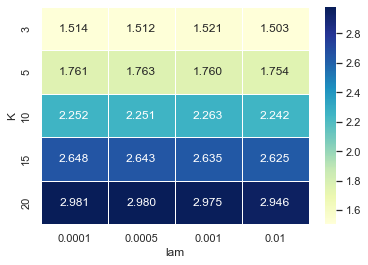

Fitting Reg-LFM: K: 3, lam: 0.01000
Reg-LFM: ite: 0; diff: 0.075 RMSE: 1.884
Reg-LFM: ite: 1; diff: 0.070 RMSE: 1.815
Reg-LFM: ite: 2; diff: 0.064 RMSE: 1.751
Reg-LFM: ite: 3; diff: 0.059 RMSE: 1.692
Reg-LFM: ite: 4; diff: 0.054 RMSE: 1.638
Reg-LFM: ite: 5; diff: 0.050 RMSE: 1.588
Reg-LFM: ite: 6; diff: 0.046 RMSE: 1.542
Reg-LFM: ite: 7; diff: 0.042 RMSE: 1.500
Reg-LFM: ite: 8; diff: 0.039 RMSE: 1.461
Reg-LFM: ite: 9; diff: 0.035 RMSE: 1.426


In [24]:
aug_pair, aug_rating_res = np.vstack((train_pair, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "sLFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## GLB_item_user_mean_LFM (performance in public leaderboard: 1.33451)

* We keep both item mean and user mean, but try to add back glb mean for experiment
* Hyperparameters: K = 3, lamda = 0.00010 were used after 5-Fold Cross Validation.


5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.106, valid_rmse: 2.212
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.044, valid_rmse: 2.027
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.076, valid_rmse: 2.082
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.039, valid_rmse: 2.163
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.019, valid_rmse: 2.010
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.986, valid_rmse: 2.050
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.171, valid_rmse: 2.227
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.094, valid_rmse: 2.141
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.113, valid_rmse: 2.124
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 2.011, valid_rmse: 2.057
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.062, valid_rmse: 2.069
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.046, valid_rmse: 2.129
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.074, valid_rmse: 2.050
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.051, valid_rmse: 2.113
5-Fold

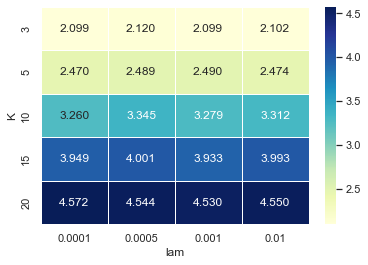

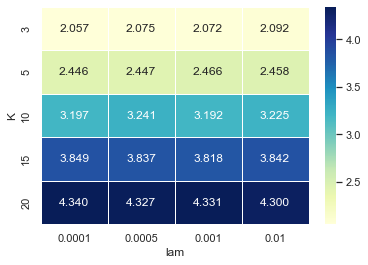

Fitting Reg-LFM: K: 3, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.009 RMSE: 2.200
Reg-LFM: ite: 1; diff: 0.009 RMSE: 2.192
Reg-LFM: ite: 2; diff: 0.008 RMSE: 2.183
Reg-LFM: ite: 3; diff: 0.008 RMSE: 2.175
Reg-LFM: ite: 4; diff: 0.008 RMSE: 2.167
Reg-LFM: ite: 5; diff: 0.008 RMSE: 2.158
Reg-LFM: ite: 6; diff: 0.008 RMSE: 2.150
Reg-LFM: ite: 7; diff: 0.008 RMSE: 2.142
Reg-LFM: ite: 8; diff: 0.008 RMSE: 2.134
Reg-LFM: ite: 9; diff: 0.008 RMSE: 2.126


In [26]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# item_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

# user_mean
train_rating_res -= item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
train_rating_res -= user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "GLB_user_item_LFM"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## user_item_LFM_userRS (performance in public leaderboard: 1.13755)
(i) Any hyperparameters? how to tune; (ii)Any issue? (iii) how to make improvement.
* We keep both item mean and user mean again, but try to add a new cor parameter 
* Hyperparameters: K = 15, lam = 0.00035 were used after 5-Fold Cross Validation.
* The Rmse is larger than the user_item_mean_LFM model

5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.796, valid_rmse: 3.933
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.769, valid_rmse: 3.852
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.699, valid_rmse: 3.838
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.798, valid_rmse: 3.957
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 3.816, valid_rmse: 4.010
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.742, valid_rmse: 3.962
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.776, valid_rmse: 3.798
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.824, valid_rmse: 3.900
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.707, valid_rmse: 3.888
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 3.789, valid_rmse: 3.988
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.737, valid_rmse: 3.924
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.705, valid_rmse: 3.886
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.834, valid_rmse: 4.008
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 3.829, valid_rmse

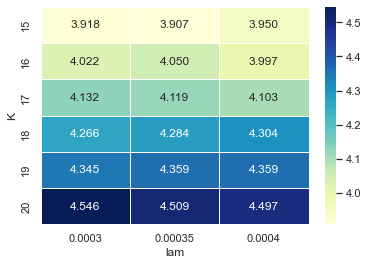

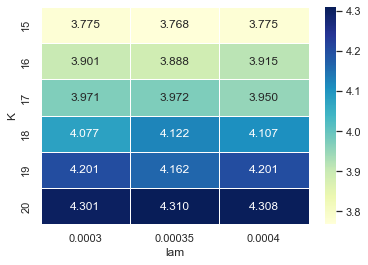

Fitting Reg-LFM: K: 15, lam: 0.00035
Reg-LFM: ite: 0; diff: 0.030 RMSE: 4.018
Reg-LFM: ite: 1; diff: 0.030 RMSE: 3.988
Reg-LFM: ite: 2; diff: 0.029 RMSE: 3.959
Reg-LFM: ite: 3; diff: 0.029 RMSE: 3.929
Reg-LFM: ite: 4; diff: 0.029 RMSE: 3.901
Reg-LFM: ite: 5; diff: 0.028 RMSE: 3.872
Reg-LFM: ite: 6; diff: 0.028 RMSE: 3.845
Reg-LFM: ite: 7; diff: 0.028 RMSE: 3.817
Reg-LFM: ite: 8; diff: 0.027 RMSE: 3.790
Reg-LFM: ite: 9; diff: 0.027 RMSE: 3.763
Reg-LFM: ite: 10; diff: 0.027 RMSE: 3.736
Reg-LFM: ite: 11; diff: 0.026 RMSE: 3.710
Reg-LFM: ite: 12; diff: 0.026 RMSE: 3.684
Reg-LFM: ite: 13; diff: 0.025 RMSE: 3.659
Reg-LFM: ite: 14; diff: 0.025 RMSE: 3.634
Reg-LFM: ite: 15; diff: 0.025 RMSE: 3.609
Reg-LFM: ite: 16; diff: 0.025 RMSE: 3.584
Reg-LFM: ite: 17; diff: 0.024 RMSE: 3.560
Reg-LFM: ite: 18; diff: 0.024 RMSE: 3.536
Reg-LFM: ite: 19; diff: 0.024 RMSE: 3.513
Reg-LFM: ite: 20; diff: 0.023 RMSE: 3.489
Reg-LFM: ite: 21; diff: 0.023 RMSE: 3.466
Reg-LFM: ite: 22; diff: 0.023 RMSE: 3.444
Reg-LFM

In [27]:
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [15,16,17,18,19,20],[0.0003,0.00035,0.0004]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam,iterNum=30)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
train_rating_res2=train_rating_res-shiing.predict(train_pair)

# fit correlation-based RS by residual ratings 
cor_user = cor_rs_user(n_user=n_user,n_item=n_item)
cor_user.fit(train_pair=train_pair, train_rating=train_rating_res2)
pred = pred + cor_user.predict(test_pair, train_pair, train_rating_res2, top=10)
pred_rating = pred

## save the prediction
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "user_item_LFM_userRS"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

# Impelement Deep Learning with Keras
NCF (performance in public leaderboard: 1.33538)  
This part is contributed by `LAW Yiu Leung Eric 1155149315`

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create the model
We embed both users and movies in to multi-dimensional vectors.  
The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.

Math formuation: $\hat{r}_{u, i} = f_L (p_u, q_i) = A(W_l f_{l-1}(p_u, q_i) + b_l)$

In [6]:
class LFactorNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(LFactorNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        concatted_vec = self.concatenate([user_vector, movie_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

## User + Item + NCF
From the previous models, we can see using global average causes RMSE to be increased, so we only use user_mean, item_mean and NCF.  
$\hat{r}_{u, i} = \bar{r}_u + \bar{r}_i + \hat{r}_{\text{NCF}}$

In [8]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

# item_mean
train_rating_res = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

train_rating_res -= item_ave.predict(train_pair)

Train the NCF model with 100-dimensional vectors, 20 epochs

In [9]:
model = LFactorNet(num_users=n_user, num_items=n_item, embedding_size=100)


metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=train_pair,
    y=train_rating_res,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=.2,
)

Epoch 1/20
192/192 [==============================] - 2s 4ms/step - loss: 2.0201 - mae: 0.9022 - rmse: 1.1630 - val_loss: 1.3716 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 2/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3578 - mae: 0.9021 - rmse: 1.1630 - val_loss: 1.3629 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 3/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 4/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 5/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 6/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoc

### RMSE of Training Dataset

In [42]:
train_pred_rating = user_ave.predict(train_pair) + item_ave.predict(train_pair) + model.predict(train_pair).flatten()
rmse(train_rating, train_pred_rating)

1.1637926707361146

## Adjustment for Final Prediction

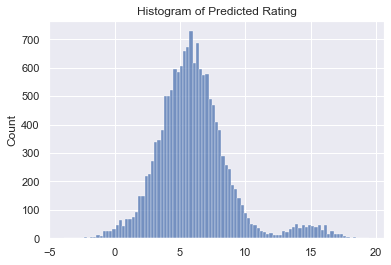

In [43]:
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating")
plt.show(g)

We can see the distribution of the prediction is similar to training rating. However, the prediction should be within [0, 15]

### Predict within [0, 15]

In [23]:
def adjust(pred_rating, score_min, score_max):
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[pred_rating > score_max] = score_max
    pred_rating_adjusted[pred_rating < score_min] = score_min
    return pred_rating_adjusted

### Adjust the Fractional Part
If the fractioanl part < 0.1, then round it down
If the fractional part > 0.9, then round it up

In [24]:
def adjust_frac(pred_rating, frac_lower, frac_upper):
    frac = pred_rating - np.fix(pred_rating)
    
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[(frac< frac_lower) | (frac > frac_upper)] = pred_rating[(frac< frac_lower) | (frac > frac_upper)].round()
    return pred_rating_adjusted

### RMSE after Adjustment

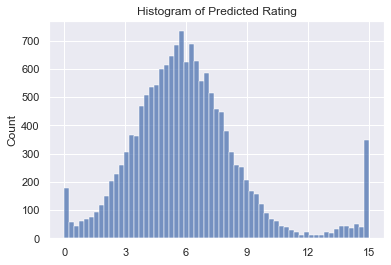

1.1428343137738166

In [34]:
train_pred_rating = adjust(train_pred_rating, 0, 15)
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating", xticks = range(0, 15+1, 3))
plt.show(g)
rmse(train_rating, train_pred_rating)

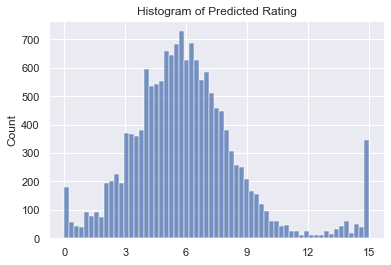

1.143303752957184

In [35]:
train_pred_rating = adjust_frac(train_pred_rating, 0.1, 0.9)
g = sns.histplot(x = train_pred_rating)
g.set(title = "Histogram of Predicted Rating", xticks = range(0, 15+1, 3))
plt.show(g)
rmse(train_rating, train_pred_rating)

We can see adjustment of the fractional part does not decrease the RMSE.

## Final Prediction

[2.48521862 4.77526723 4.7357608  ... 3.62452553 9.98011706 4.5890244 ]


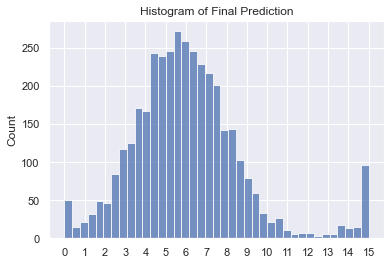

In [36]:
pred_rating = pred + model.predict(test_pair).flatten()
pred_rating = np.array(pred_rating)
pred_rating = adjust(pred_rating, 0, 15)
print(pred_rating)

g = sns.histplot(x = pred_rating)
g.set(title = "Histogram of Final Prediction", xticks = range(15+1))
plt.show(g)

# Result
This part is contributed by `TSOI Tung Sing 1155127274`
## Save to csv with timestamp

In [37]:
from datetime import datetime
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "user_item_NCF"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## Print T-th record

In [38]:
t = 315 # there are only 3826 rows in test.csv, change t to 315

print("T-th test_pair: ", test_pair[t])
print("T-th predicted rating: ", pred_rating[t])

T-th test_pair:  [124 103]
T-th predicted rating:  1.8927516209914725


## Print Top-5 Preferred Items based on `pred_rating`

In [39]:
user_id_t = test_pair[t, 0]
index = dtest[dtest["user_id"] == user_id_t].index
pred_t = pd.DataFrame({"item_id": dtest["item_id"][index], "rating": pred_rating[index]})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
2521,952,6.356096
2687,178,4.913444
2350,947,4.799069
255,96,4.774183
1678,295,4.392175


## Print Top-5 Preferred Items (including items may not been seen by the user)

In [41]:
test_pair_t = np.array([[user_id_t, item] for item in range(n_item)])
pred_rating_t = user_ave.predict(test_pair_t) + item_ave.predict(test_pair_t) + model.predict(test_pair_t).flatten()
pred_t = pd.DataFrame({"item_id": range(n_item), "rating": adjust(pred_rating_t, 0, 15)})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
252,252,13.160800
117,117,12.661375
4,4,12.101098
653,653,10.993568
943,943,10.805256


# Philosphy
This part is contributed by `LAW Yiu Leung Eric 1155149315`  and `Tsoi Tung Sing 1155149315` 
We tried many different models to predict the user-item rating, after checking the RMSE in train_rating and public score in Kaggle, we choose User+Item+LFM to be the best model.  
We notice that the prediction rating could be negative and greater than 15, which must be wrong compare to true rating. Thus, we adjust negative predictions to 0, and predictions which greater than 15 to be 15. While we thought about adjust the predictions according to the fractional part, however, this requires an assumption that the model is strongly reliable. Which turns out to be false, adjusting the fractional part increases the RMSE.  
After adjustment to range [0, 15], the public score is 1.13507.

## Mathematical Information
### Baseline
Let $n, m$ be the number of users and items respectively. For user $u$ and item $i$, where $u \in [1, n]$, $i \in [1, m]$, and $(u, i) \in \Omega$ and $r_{u, i}$ is the rating that the $u$-th user gives to $i$-th item.  
\begin{align*}
    \text{RMSE} &= \left[ \frac{1}{|\Omega|} \sum_{(u, i) \in \Omega} (\hat{r}_{u, i} - r_{u, i}) \right]^{\frac{1}{2}} \\
    \text{Global average} &= \hat{r}_{u, i} = \bar{r} = \frac{1}{|\Omega|} \sum_{(u, i) \in \Omega} r_{u, i} \\
    \text{User average} &= \hat{r}_{u, i} = \bar{r}_u =  \frac{1}{|I_u|} \sum_{i \in I_u} r_{u, i}, \text{ where } I_u = \{ i | (u, i) \in \Omega \} \\
    \text{Item average} &= \hat{r}_{u, i} = \bar{r}_i =  \frac{1}{|U_i|} \sum_{i \in U_i} r_{u, i}, \text{ where } U_i = \{ u | (u, i) \in \Omega \} \\
    \text{User-item average} &= \hat{r}_{u, i} = \bar{r} + \mu_u + \mu_i = \bar{r} + \frac{1}{|I_u|} \sum_{i \in I_u} (r_{u, i} - \bar{r}) + \frac{1}{|U_i|} \sum_{u \in U_i} (r_{u, i} - \bar{r} - \mu_u)
\end{align*}

### Correlation
For users $(u, u')$, pairwise cosine similarity between users:
\begin{align*}
    \mathtt{sim} (u, u') = \mathtt{cos} (r_u, r_{u'}) &= \frac{\sum_{i=1}^m r_{u, i} r_{u', i}}{||r_u||_2 ||r_{u'}||_2} \\
    \text{Correlation based RS}: \hat{r}_{u, i} &= \sum_{u' \in U_i} \frac{\mathtt{sim} (u, u') r_{u', i}}{\sum_{u' \in U_i} \mathtt{sim} (u, u')}
\end{align*}

### Latent Factor Model
Introduce $K$-length latent factors $p_u, q_i$ for the user $u$, item $i$, $p_u = (p_{u1}, \dots, p_{uK})^T$ and $q_i = (q_{i1}, \dots, q_{iK})^T$. Let $\lambda \in (0, \infty)$ be a turning parameter.
\begin{equation*}
    \hat{r}_{u, i} = p_u^T q_i \rightarrow r_{u, i}
\end{equation*}
We estimate the parameters $p, q$ by minimizing **RMSE**
\begin{equation*}
    (p, q) = \argmin_{p, q} \frac{1}{|\Omega|} \sum_{(u, i) \in \Omega} (r_{u, i} - p^T_u q_i)^2 + \lambda \left( \sum_{u=1}^n ||p_u||_2^2 + \sum_{i=1}^m ||q_i||_2^2 \right)
\end{equation*}
Using cross-validation to determine the optimal tuning parameters $(K, \lambda)$, denote as $K^*$ and $\lambda^*$, then refit the model based on full training data with $K^*$ and $\lambda^*$

**Global + User + Item + LFM**
\begin{equation*}
    \hat{r}_{u, i} = \hat{r}_{u, i} = \bar{r} + \mu_u + \mu_i + \delta_{u, i} = \bar{r} + \frac{1}{|I_u|} \sum_{i \in I_u} (r_{u, i} - \bar{r}) + \frac{1}{|U_i|} \sum_{u \in U_i} (r_{u, i} - \bar{r} - \mu_u) + p_u^T q_i
\end{equation*}
where LFM model is trained by the residuals:
\begin{equation*}
    (p, q) = \argmin_{p, q} \frac{1}{|\Omega|} \sum_{(u, i) \in \Omega} (r_{u, i} - \bar{r} - \mu_u - \mu_i - p^T_u q_i)^2 + \lambda \left( \sum_{u=1}^n ||p_u||_2^2 + \sum_{i=1}^m ||q_i||_2^2 \right)
\end{equation*}

### Neural Collaborative Filtering
We implement NCF by using TensorFlow and Keras
\begin{equation*}
    \hat{r}_{u, i} = f_L (p_u, q_i) = A(W_l f_{l-1}(p_u, q_i) + b_l)
\end{equation*}